In [65]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import time
from PIL import Image

from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [66]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose(
        [T.Resize(32), T.ToTensor()]
    )
)

In [67]:
train_data[0][0].shape

torch.Size([1, 32, 32])

In [68]:
to_pil_image = T.ToPILImage()

# GAN

In [69]:
class Generator(nn.Module):
    def __init__(self, generator_input_size=128):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(generator_input_size, 64, kernel_size=4, stride=1, padding=0, bias=False)
        self.norm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(16)

        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.sigmoid(self.conv4(x))
        return x

In [70]:
class Expert(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    

In [80]:
def train_expert(generator_net, expert_net, real_inputs, optimizer, batch_size, input_size = 128):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Real input
    real_labels = torch.ones(batch_size, 1, device=device)

    # Generated input
    generator_inputs = torch.randn(batch_size, input_size, 1, 1, device=device)
    generated_inputs = generator_net(generator_inputs)
    generated_labels = torch.zeros(batch_size, 1, device=device)
    
    # Forward
    generated_outputs = expert_net(generated_inputs)
    generated_loss = F.binary_cross_entropy(generated_outputs, generated_labels)
    real_outputs = expert_net(real_inputs)
    real_loss = F.binary_cross_entropy(real_outputs, real_labels)

    # Backward
    generated_loss.backward()
    real_loss.backward()
    optimizer.step()
    
    return generated_loss + real_loss

def train_generator(generator_net, expert_net, optimizer, batch_size, input_size = 128):
    optimizer.zero_grad()
    
    # Fake input
    generator_inputs = torch.randn(batch_size, input_size, 1, 1, device=device)
    generated_inputs = generator_net(generator_inputs)
    generated_labels = torch.ones(batch_size, 1, device=device)

    generated_outputs = expert_net(generated_inputs)
    loss = F.binary_cross_entropy(generated_outputs, generated_labels)
     
    loss.backward()
    optimizer.step()
    
    return loss

def train(generator_net, expert_net, train_data, batch_size=10, learning_rate=0.0001, epochs=10):
    criterion = nn.BCELoss()
    expert_optimizer = optim.Adam(expert_net.parameters(), lr=learning_rate)
    generator_optimizer = optim.Adam(generator_net.parameters(), lr=learning_rate)

    input_size = train_data[0][0].shape[0]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    running_expert_loss = []
    running_generator_loss = []


    for epoch in range(epochs):
        print("Epoch:" , epoch+1)

        for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
            inputs, _ = data
            inputs = inputs.to(device)

            expert_loss = train_expert(
                generator_net,
                expert_net,
                inputs,
                expert_optimizer,
                batch_size
            )
            running_expert_loss.append(expert_loss.item())
            
            generator_loss = train_generator(
                generator_net,
                expert_net,
                generator_optimizer,
                batch_size
            )
            running_generator_loss.append(generator_loss.item())
        
        
        generator_inputs = torch.randn(64, 128, 1, 1, device=device)
        generated_img = generator_net(generator_inputs)
        generated_img = make_grid(generated_img)

        #SAVE IMAGE
        im = Image.fromarray(np.array(to_pil_image(generated_img)))
        im.save(f"Images_output/gan_cnn/epoch_{epoch}.jpeg")

        print(f'Loss: {np.mean(running_generator_loss[-len(train_data):])}, {np.mean(running_expert_loss[-len(train_data):])}')

    return running_expert_loss, running_generator_loss



In [81]:
# Initialise nets
input_size = train_data[0][0].shape[0]
expert_net = Expert(input_size)
expert_net.to(device)

generator_net = Generator()
generator_net.to(device)


Generator(
  (conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [ ]:
# Train
loss = train(generator_net, expert_net, train_data, epochs=50)

  0%|          | 3/6000 [00:00<03:28, 28.70it/s]

Epoch: 1


  0%|          | 5/6000 [00:00<02:12, 45.20it/s]

Loss: 1.5186277880867323, 0.8199270059963067
Epoch: 2


  0%|          | 5/6000 [00:00<02:12, 45.32it/s]

Loss: 1.327688998480638, 0.9210689702481032
Epoch: 3


  0%|          | 5/6000 [00:00<02:12, 45.41it/s]

Loss: 1.3210021334638198, 0.9121558480328984
Epoch: 4


  0%|          | 5/6000 [00:00<02:11, 45.59it/s]

Loss: 1.3775488060228527, 0.8778246541370948
Epoch: 5


  0%|          | 5/6000 [00:00<02:11, 45.56it/s]

Loss: 1.4367798529475928, 0.8482339938819409
Epoch: 6


  0%|          | 5/6000 [00:00<02:11, 45.54it/s]

Loss: 1.4877793738668164, 0.8256258058481746
Epoch: 7


  0%|          | 5/6000 [00:00<02:11, 45.55it/s]

Loss: 1.536926356644148, 0.8065815251150301
Epoch: 8


  0%|          | 5/6000 [00:00<02:11, 45.58it/s]

Loss: 1.5814116796981543, 0.7895368077956761
Epoch: 9


  0%|          | 5/6000 [00:00<02:11, 45.75it/s]

Loss: 1.6220691522641315, 0.7746086040702131
Epoch: 10


  0%|          | 5/6000 [00:00<02:11, 45.63it/s]

Loss: 1.660046896780034, 0.7618772687268753
Epoch: 11


  0%|          | 5/6000 [00:00<02:11, 45.76it/s]

Loss: 1.711702492929995, 0.7440541134571036
Epoch: 12


  0%|          | 5/6000 [00:00<02:10, 45.92it/s]

Loss: 1.8051093085313836, 0.7057170408266286
Epoch: 13


  0%|          | 5/6000 [00:00<02:11, 45.58it/s]

Loss: 1.8835928198466698, 0.6797418025734524
Epoch: 14


  0%|          | 5/6000 [00:00<02:10, 45.82it/s]

Loss: 1.9388792903418341, 0.665430044542253
Epoch: 15


  0%|          | 5/6000 [00:00<02:10, 45.81it/s]

Loss: 1.9843620200152199, 0.654431261248514
Epoch: 16


  0%|          | 5/6000 [00:00<02:10, 45.78it/s]

Loss: 2.0255756857429943, 0.6438863565225155
Epoch: 17


  0%|          | 5/6000 [00:00<02:11, 45.65it/s]

Loss: 2.060519488309324, 0.6345530581720173
Epoch: 18


  0%|          | 5/6000 [00:00<02:11, 45.51it/s]

Loss: 2.0919266521429023, 0.6272739111666878
Epoch: 19


  0%|          | 5/6000 [00:00<02:11, 45.49it/s]

Loss: 2.1165632827594876, 0.6204715533643961
Epoch: 20


  0%|          | 5/6000 [00:00<02:13, 45.01it/s]

Loss: 2.1367582764074204, 0.6140973612481108
Epoch: 21


 73%|███████▎  | 4369/6000 [01:37<00:35, 45.46it/s]

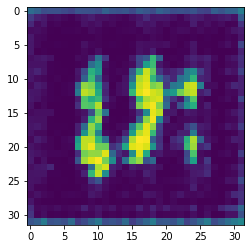

In [61]:
# Test image
generator_inputs = torch.randn(64, 128, 1, 1, device=device)
generated_inputs = generator_net(generator_inputs)
generated_img = make_grid(generated_inputs)
plt.imshow(generated_inputs.view(8,8,32,32).detach().numpy())